# Binary Classifier Comparison

### Achievement

Using the machine learning algorithm of gradient boosted trees in combination with hyperparameter optimization we create a binary classifier, able to distinguish benign from malicious network traffic, with the following performance characteristics:

|PR Score|Precision Positive|Recall Positive|False-Positives|False-Negatives|
|---|---|---|---|---|
|0.98266|0.964|0.957|9784|11748|

The classifier created in this notebook yields the best performance yet, compared to the estimators trained in previous experiments.


## 1. Introduction

In this notebook, we will compare different supervised machine learning approaches to create a binary classifier, able to identify malicious network traffic.     

In particular, we will compare the following algorithms:
* [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) Classifier using [scikit-learn](https://scikit-learn.org/stable/index.html),
* [Gradient Boosted Tree](https://catboost.ai/docs/concepts/python-reference_catboostclassifier.html) Classifier using the [CatBoost](https://catboost.ai/docs/) library and a
* Deep Neural Network using [Keras](https://keras.io/) and [Tensorflow 2](https://www.tensorflow.org/).

The approaches presented in this notebook were explored in detail in the course of previous experiments and can be examined in the notebooks [ML Prototype](https://github.com/cstub/ml-ids/blob/master/notebooks/03_ml-prototype/ml-prototype.ipynb) and [Deep Learning Classifier](https://github.com/cstub/ml-ids/blob/master/notebooks/06_dl_classifier/dl-classifier.ipynb). 

To ensure a fair comparison of the different models, we will conduct hyperparameter search and optimization for the Random Forest and Gradient Boosted Tree algorithms, as the previous experiments used the default parameters of both algorithms for training. We will utilize the [Hyperopt library](https://github.com/hyperopt/hyperopt) to perform hyperparameter search.    
The Deep Neural Network presented in this notebook has already been fine-tuned via hyperparameter search in a previous [experiment](https://github.com/cstub/ml-ids/blob/master/notebooks/06_dl_classifier/dl-classifier.ipynb) and will not be retrained, but rather used as created in this experiment.

After training and fine-tuning, we will compare the models based on their respective performances on the validation set and select the best performing model. Subsequently, this model will be evaluated on the test set, to obtain an unbiased estimate of the performance of the model.

The data used to train and compare the models is taken from the [CIC-IDS-2018 dataset](https://www.unb.ca/cic/datasets/ids-2018.html).

## 2. Dataset Preparation

In this section we load the dataset and prepare the data for training. The preprocessed dataset from CIC-IDS-2018 can be found at [Google Drive](https://drive.google.com/open?id=1HrTPh0YRSZ4T9DLa_c47lubheKUcPl0r).

In [1]:
dataset_base_path = r'/home/glados/Development/Projects/ids-2018/processed'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import uuid
import joblib as jl
import ml_ids.keras.prediction as kp
import tensorflow as tf
from ml_ids.data.dataset import load_dataset
from ml_ids.data.metadata import FEATURES_NO_VARIANCE
from ml_ids.visualization import plot_hist, print_binary_performance, plot_pr_curve, plot_pr_curves, plot_pr_threshold_curves
from ml_ids.keras.metrics import AveragePrecisionScoreMetric
from ml_ids.model_selection import best_precision_for_target_recall
from ml_ids.prediction import predict_proba_positive, predict_decision_boundary
from ml_ids.tf_utils import enable_gpu_memory_growth
from notebook_utils import transform_data, get_best_model_path, print_trial_results
from sklearn.metrics import average_precision_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from tensorflow.keras import models
from hyperopt import fmin, hp, tpe, atpe, Trials, STATUS_OK
from hyperopt.plotting import main_plot_history, main_plot_vars


rand_state = 42
tf.random.set_seed(rand_state)
np.random.seed(rand_state)

enable_gpu_memory_growth()

%matplotlib inline

%load_ext autoreload
%autoreload 2

### 2.1 Data Loading & Preparation

In this part we load the dataset, specifing the features to omit. These encompass all features having no variance and features which should not be taken into account, in order to obtain a better generalization of the model.

We use `median` imputation as the strategy to impute missing values, as the distributions of all features, for which imputation is necessary, are highly skewed. 
Futhermore, we scale the data using a `StandardScaler`, as the neural network demands the data to be scaled, and upsample the malicious network traffic to obtain `100000` samples per attack category. We perform upsampling by using the technique of Synthetic Minority Over-sampling provided by the [SMOTE](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html) library.

Subsequently, the dataset is splitted into:
* training set,
* validation set and
* test set.

In [3]:
dataset = load_dataset(dataset_base_path,
                       omit_cols=FEATURES_NO_VARIANCE + ['timestamp', 'dst_port', 'protocol'],
                       preserve_neg_value_cols=['init_fwd_win_byts', 'init_bwd_win_byts'])

X_train, y_train, X_val, y_val, X_test, y_test, column_names = transform_data(dataset=dataset,
                                                                              imputer_strategy='median',
                                                                              scaler=StandardScaler,
                                                                              attack_samples=100000,
                                                                              random_state=rand_state)

del dataset

Samples:
Training: (12986354, 68)
Val:      (1623294, 68)
Test:     (1623295, 68)

Training labels:
Benign                      10787766
DDOS attack-HOIC              548809
DDoS attacks-LOIC-HTTP        460953
DoS attacks-Hulk              369530
Bot                           228953
FTP-BruteForce                154688
SSH-Bruteforce                150071
Infilteration                 129547
DoS attacks-SlowHTTPTest      111912
DoS attacks-GoldenEye          33206
DoS attacks-Slowloris           8792
DDOS attack-LOIC-UDP            1384
Brute Force -Web                 489
Brute Force -XSS                 184
SQL Injection                     70
Name: label, dtype: int64

Validation labels:
Benign                      1348471
DDOS attack-HOIC              68601
DDoS attacks-LOIC-HTTP        57619
DoS attacks-Hulk              46191
Bot                           28619
FTP-BruteForce                19336
SSH-Bruteforce                18759
Infilteration                 16193
DoS attacks

### 2.2 Target Grouping & Class Weight Calculation

In this step we create the binary target variable by grouping all malicious network traffic into a single attack category represented by the positive class `1`, whereas benign traffic is represented as the negative class `0`.

Furthermore, we calculate the weights for each class, given by the proportion of samples of this class in the training set.   
For the majority class, the class weight is `1`.   
For the minority class, the class weight is calculated with the following formula:
\begin{align}
\frac{(sum\_majority\_class)}{(sum\_minority\_class)} \\
\end{align}
In our case this translates to:
\begin{align}
\frac{(sum\_negative\_class)}{(sum\_positive\_class)} \\
\end{align}

In [4]:
y_train_is_attack = (y_train != 0).astype('int')

minority_class_weight = len(y_train_is_attack[y_train_is_attack == 0]) / len(y_train_is_attack[y_train_is_attack == 1])

class_weights = { 
    0: 1, 
    1: minority_class_weight
}

class_weights_catboost = [1, minority_class_weight]

## 3. Random Forest Model

### 3.1 Hyperparameter Search-Space Definition and Training

In this section of the notebook, we train a [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) using scikit-learn. We aim to find the optimal parameter configuration for the Random Forest algorithm by conducting hyperparameter search via Hyperopt.

To use Hyperopt, we have to define the search-spaces for all parameters that should be optimized. The search-spaces are defined as follows:
* Number of tree estimators *(n_estimators)*: uniform integer space in the interval of `[10, 100]`.
* Information gain criterion *(criterion)*: choice of `gini` or `entropy`.
* Maximum depth of a single tree *(max_depth)*: uniform integer space in the interval of `[10, 100]` or `None` resulting in an unbounded tree.
* Maximum features for the best split *(max_features)*: choice of `sqrt` or `log2`.
* Minimum samples to split a node *(min_samples_split)*: uniform integer space in the interval of `[1, 10]`.
* Minimum samples at a leaf node *(min_samples_leaf)*: uniform integer space in the interval of `[2, 10]`.

Training is performed on `50` models, using the [Tree of Parzen Estimators (TPE)](https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf) search algorithm provided by Hyperopt, to optimize the search process. 

In [7]:
def train_random_forest(args):
    print('\nRun') 
    print('==========')
    print('Parameters:\n{}'.format(args))
    
    nr_estimators = int(args['nr_estimators'])
    criterion = args['criterion']
    max_depth = int(args['max_depth']['depth']) if args['max_depth']['depth'] else None
    max_features = args['max_features']
    min_samples_split = int(args['min_samples_split'])
    min_samples_leaf = int(args['min_samples_leaf'])
    
    model_path = 'models/rf_{}.joblib'.format(uuid.uuid4())
    
    clf = RandomForestClassifier(n_estimators=nr_estimators,
                                 criterion=criterion,
                                 max_depth=max_depth,
                                 max_features=max_features,
                                 min_samples_split=min_samples_split,
                                 min_samples_leaf=min_samples_leaf,
                                 class_weight='balanced',
                                 n_jobs=-1,
                                 verbose=1,
                                 random_state=rand_state)
    
    clf.fit(X_train, y_train_is_attack)
    
    pred = predict_proba_positive(clf, X_val)
    pr_score = average_precision_score(y_val.label_is_attack, pred)
    
    jl.dump(clf, model_path)

    print('PR Score: {}'.format(pr_score))
    
    return {
        'loss': -pr_score,
        'status': STATUS_OK,
        'model_path': model_path
    }

In [ ]:
trials_rf = Trials()

space = { 
    'nr_estimators': hp.quniform('nr_estimators', 10, 100, 1),
    'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'max_depth': hp.choice('max_depth', [
        {
            'depth': None
        },
        {
            'depth': hp.quniform('nr_max_depth', 10, 100, 1),
        }
    ]),  
    'max_features': hp.choice('max_features', ['sqrt', 'log2']),
    'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1)
}

best_run_rf = fmin(fn=train_random_forest,
                   space=space,
                   algo=tpe.suggest,
                   max_evals=50,
                   trials=trials_rf)

[Output omitted for brevity]

### 3.2 Hyperparameter Search Results

After completion of the hyperparameter search, we plot the parameter search-spaces and highlight the values used for the ten best performing models in each respective search-space.    
Evaluating the hyperparameter search results, we can infer the following optimal value-ranges for each parameter:

* Number of tree estimators: the optimal number of tree estimators seems to be in the interval of `[60, 100]`.
* Information gain criterion: the `entropy` criterion yields a better performance than the `gini` criterion in our search run.
* Maximum depth of a single tree: restricting the depth of the trees seems to perform better than using unrestricted trees. A value in the interval of `[20, 50]` for the maximum tree depth yields a good performance.
* Maximum features for the best split: the `sqrt` option seems to perform better than `log2`.
* Minimum samples to split a node: the optimal number of minimum samples to split a node is in the interval of `[4, 6]`.
* Minimum samples of a leaf node: given our search run, there is no conclusive best option for the minimum numbers of samples in a leaf node. However, the values `{3, 6, 7, 8}` seem to perform well.

avg best error: -0.9810239466346429


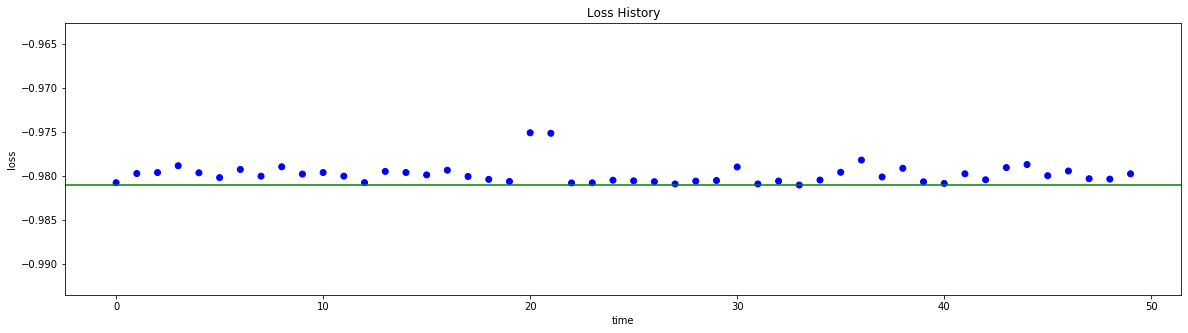

finite loss range -0.9810239466346429 -0.9751055486286375 -0.9805809112883349


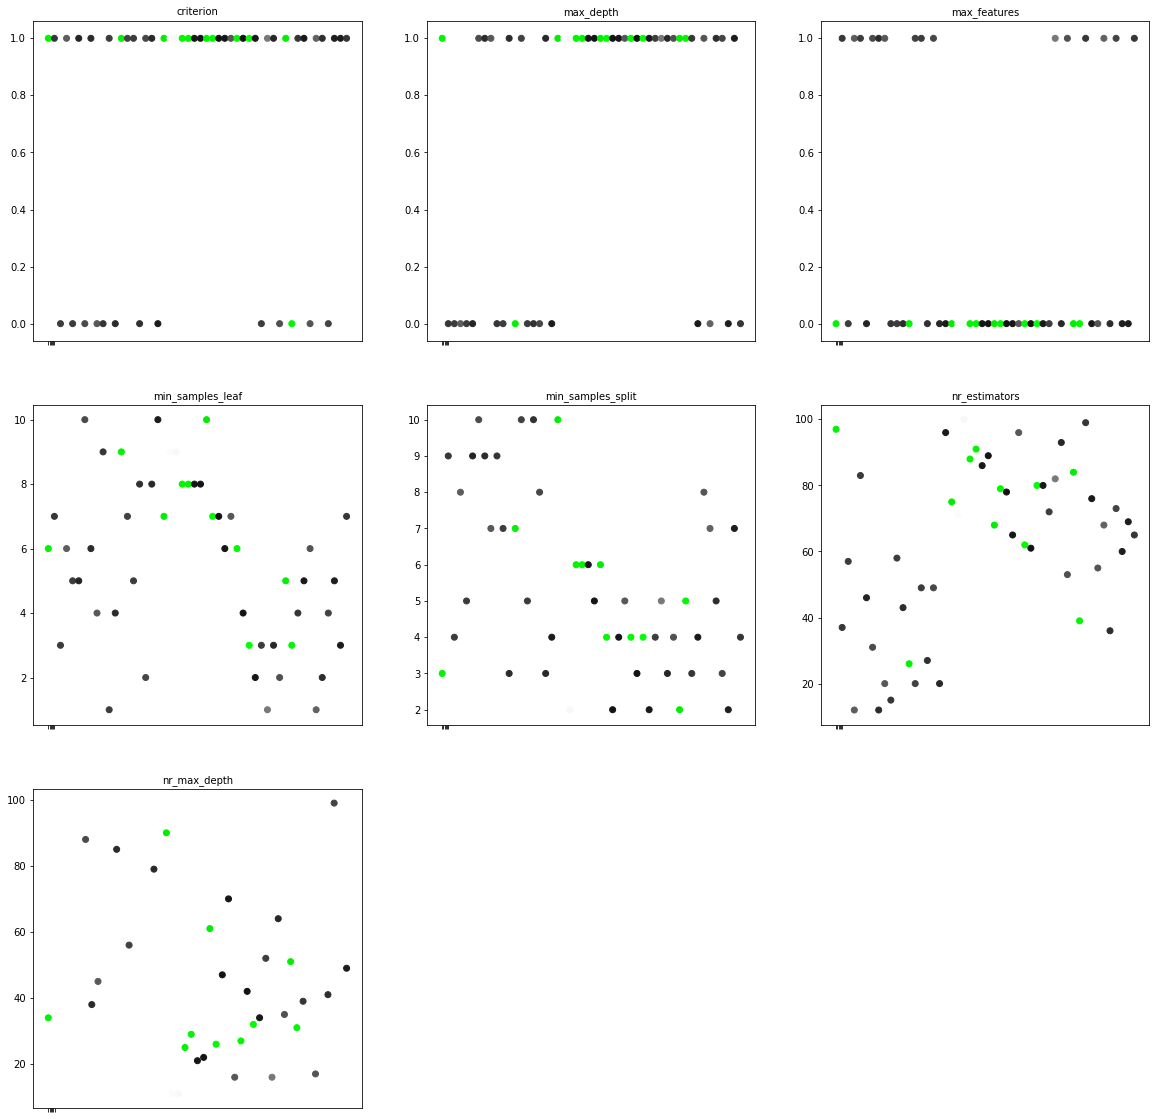

In [14]:
plt.figure(figsize=(20, 5))
main_plot_history(trials_rf)

plt.figure(figsize=(20, 20))
main_plot_vars(trials_rf, columns=3, colorize_best=10, arrange_by_loss=False)

### 3.3 Optimal Model Parameters

Looking at the best performing model, we can observe the following parameter configuration:
* `80` tree estimators,
* the `entropy` information gain criterion,
* a maximum depth of `32` nodes per tree,
* `sqrt` as the selector for the maximum number of features considered when splitting a node,
* a minimum of `3` samples per leaf node and
* a minimum of `4` samples necessary to split a node.

In [15]:
print_trial_results(trials_rf, best_run_rf)

Best validation score: 0.9810239466346429
Best model path: models/rf_1af6dcf7-4407-469b-89a0-b2b78661b00e.joblib

Best model parameters:
{'criterion': 1, 'max_depth': 1, 'max_features': 0, 'min_samples_leaf': 3.0, 'min_samples_split': 4.0, 'nr_estimators': 80.0, 'nr_max_depth': 32.0}


### 3.4 Performance

The Random Forest model yields a PR score of `0.9810`, with a precision of `0.967` and a recall of `0.955` in respect to the positive class.    
The model performs quite well, with the exception of the attack category `Infiltration`.

In [16]:
clf_rf = jl.load(get_best_model_path(trials_rf))

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=24)]: Done  80 out of  80 | elapsed:    2.9s finished


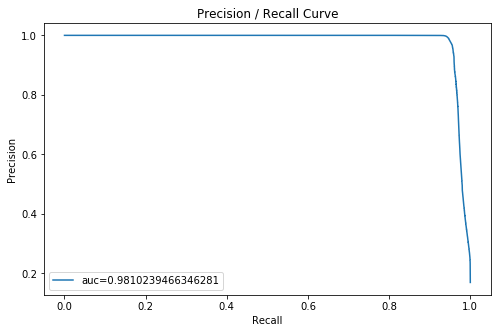

Average PR Score 0.9810239466346281


In [17]:
pred_val_proba_rf = predict_proba_positive(clf_rf, X_val)
plot_pr_curve(y_val.label_is_attack.values, pred_val_proba_rf)

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=24)]: Done  80 out of  80 | elapsed:    2.8s finished


Classification Report:
              precision    recall  f1-score   support

           0      0.991     0.993     0.992   1348471
           1      0.967     0.955     0.961    274823

    accuracy                          0.987   1623294
   macro avg      0.979     0.974     0.977   1623294
weighted avg      0.987     0.987     0.987   1623294

Confusion Matrix:


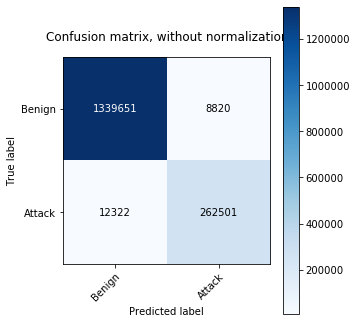

Misclassifications by attack category:


,misclassified,total,percent_misclassified
Infilteration,12252,16193,0.756623
SQL Injection,1,9,0.111111
Brute Force -Web,4,61,0.065574
Brute Force -XSS,1,23,0.043478
DoS attacks-Slowloris,8,1099,0.007279
Benign,8820,1348471,0.006541
Bot,17,28619,0.000594
DDOS attack-HOIC,22,68601,0.000321
DDoS attacks-LOIC-HTTP,17,57619,0.000295


In [18]:
pred_val_rf = clf_rf.predict(X_val)
print_binary_performance(y_val, y_val.label_is_attack, pred_val_rf)

## 4. Gradient Boosted Tree Model

### 4.1 Hyperparameter Search-Space Definition and Training

In this section, we train a [Gradient Boosted Tree Classifier](https://catboost.ai/docs/concepts/python-reference_catboostclassifier.html) utilizing the [CatBoost](https://catboost.ai/docs/) library.

Once again, we perform hyperparameter search to find the optimal parameter configuration for the algorithm, given our trainging data. 
The parameter search-spaces are defined as follows:
* Maximum number of trees *(nr_iterations)*: uniform integer space in the interval of `[100, 2000]`.
* Maximum depth of a tree *(depth)*: uniform integer space in the interval of `[4, 10]`.
* L2 regularization coefficient *(l2_leaf_reg)*: uniform space in the interval of `[1, 10]`.
* Number of splits for numerical features *(border_count)*: a choice of `128` and `254`.
* Amount of randomness used for scoring splits *(random_strength)*: uniform integer space in the interval of `[0, 5]`.

For a more detailed explanation of the individual parameters consult the CatBoost documentation on [parameter tuning](https://catboost.ai/docs/concepts/parameter-tuning.html).

Training is performed on `100` models using the Tree of Parzen Estimators (TPE) search algorithm.

In [9]:
train_pool = Pool(X_train, y_train_is_attack)
val_pool = Pool(X_val, y_val.label_is_attack)

NR_LOGS = 10

In [10]:
def train_gradient_boost(args):
    print('\nRun') 
    print('==========')
    print('Parameters:\n{}'.format(args))
    
    nr_iterations = int(args['nr_iterations'])
    tree_depth = int(args['tree_depth'])
    l2_reg = args['l2_reg']
    border_count = int(args['border_count'])
    random_strength = int(args['random_strength'])
    
    model_path = 'models/gb_{}.catboost'.format(uuid.uuid4())
    
    clf = CatBoostClassifier(loss_function='Logloss',                     
                             iterations=nr_iterations,
                             depth=tree_depth,
                             l2_leaf_reg=l2_reg,
                             border_count=border_count,
                             random_strength=random_strength,
                             task_type='GPU',
                             class_weights=class_weights_catboost,
                             verbose=(nr_iterations // NR_LOGS),
                             random_seed=rand_state)

    clf.fit(train_pool, eval_set=val_pool)
    
    pred = predict_proba_positive(clf, val_pool)
    pr_score = average_precision_score(y_val.label_is_attack, pred)
    
    clf.save_model(model_path)
    
    print('PR Score: {}'.format(pr_score))
    
    return {
        'loss': -pr_score,
        'status': STATUS_OK,
        'model_path': model_path
    }

In [ ]:
trials_gb = Trials()

space = { 
    'nr_iterations': hp.quniform('nr_iterations', 100, 2000, 100),
    'tree_depth': hp.quniform('tree_depth', 4, 10, 1),
    'l2_reg': hp.uniform('l2_reg', 1, 10),
    'border_count': hp.choice('border_count', [128, 254]),
    'random_strength': hp.quniform('random_strength', 0, 5, 1)
}

best_run_gb = fmin(fn=train_gradient_boost,
                   space=space,
                   algo=tpe.suggest,
                   max_evals=100,
                   trials=trials_gb)

[Output omitted for brevity]

### 4.2 Hyperparameter Search Results

After completion of the hyperparameter search, we inspect the results by plotting the parameter values per search-space and highlight the values resulting in the ten best performing models. 

From the plots we can infer the following optimal value-ranges per parameter:
* Maximum number of trees *(nr_iterations)*: a value in the interval of `[1600, 1900]` seems to perform best.
* Maximum depth of a tree *(depth)*: the optimal value for the maximum dept of trees is `10` in all best performing cases. This suggests that another round of hyperparameter search with a higher value might yield a better result.
* L2 regularization coefficient *(l2_leaf_reg)*: a value in the interval of `[2, 6]` yields good results.
* Number of splits for numerical features *(border_count)*: a border count of `254` was chosen for all of the best models.
* Amount of randomness used for scoring splits *(random_strength)*: the optimal value seems to be in the inteval of `[3, 5]`.

avg best error: -0.9826628201037251


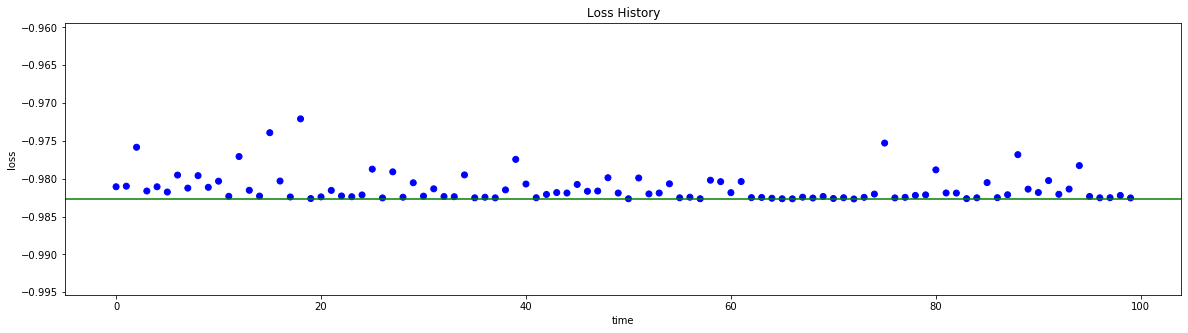

finite loss range -0.9826628201037251 -0.9720802673898308 -0.9825280984036184


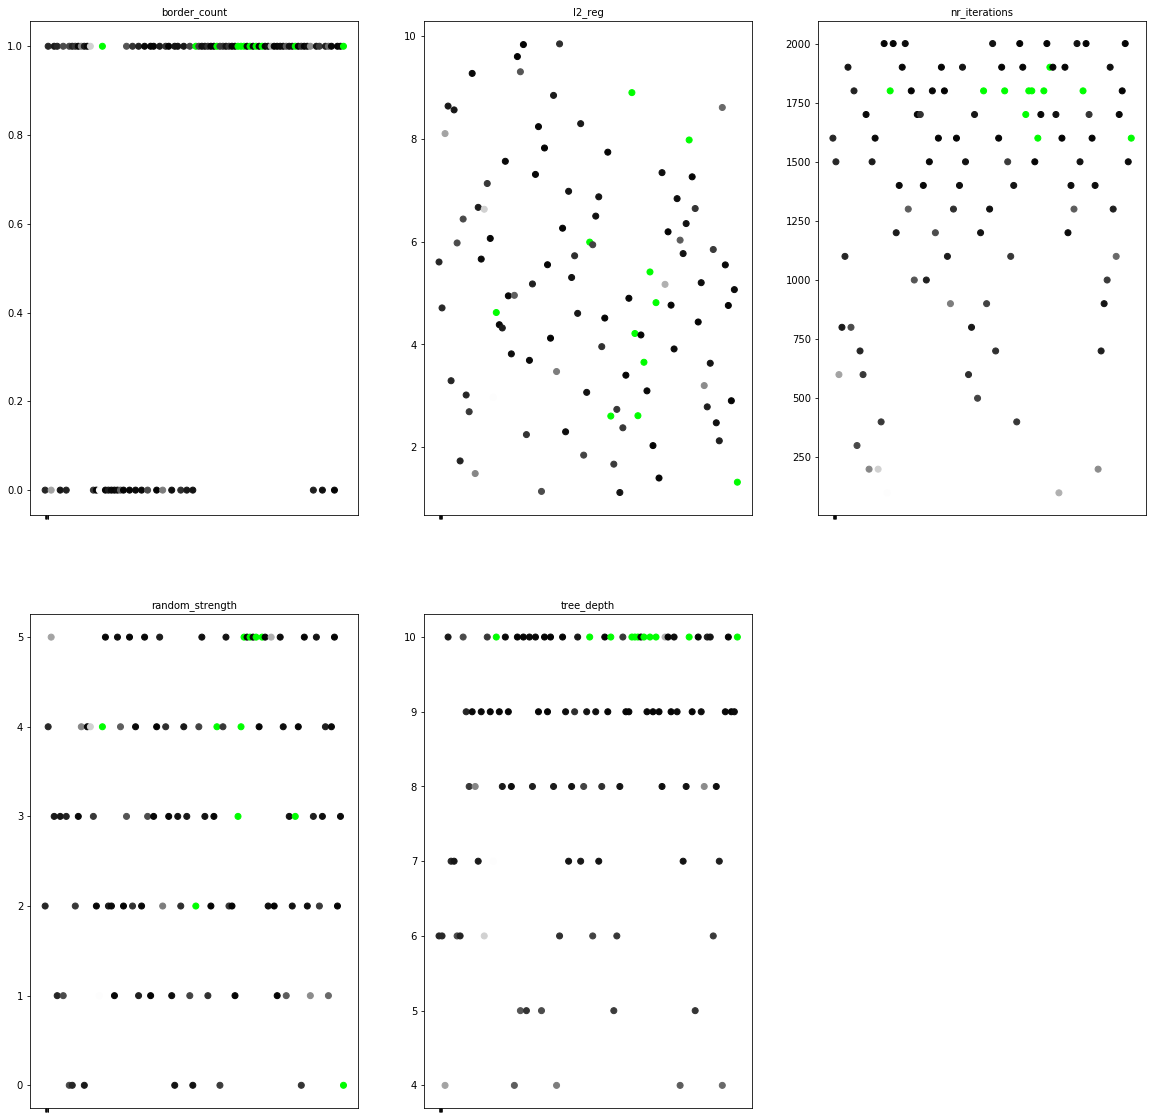

In [19]:
plt.figure(figsize=(20, 5))
main_plot_history(trials_gb)

plt.figure(figsize=(20, 20))
main_plot_vars(trials_gb, columns=3, colorize_best=10, arrange_by_loss=False)

### 4.3 Optimal Model Parameters

The optimal parameter configuration obtained via the best performing model is as follows:
* usage of `1900` trees, 
* a maximum depth of `10` per tree,
* a L2 regularization coefficient of `4.8139`,
* a border count of `254` and
* a random strenght parameter of `5`.

In [20]:
print_trial_results(trials_gb, best_run_gb)

Best validation score: 0.9826628201037251
Best model path: models/gb_835066e8-2427-48ca-a521-67195008cb91.catboost

Best model parameters:
{'border_count': 1, 'l2_reg': 4.813919374945952, 'nr_iterations': 1900.0, 'random_strength': 5.0, 'tree_depth': 10.0}


### 4.4 Performance

We obtain a model with a PR score of `0.9826`, a precision of `0.964` and a recall of `0.957` for the positive class.    
Looking at the confusion matrix and misclassification report, we observe a generally well performing model with the exception of the `Infiltration` attack category, which has a rather high misclassification rate.

In [21]:
clf_gb = CatBoostClassifier()
clf_gb.load_model(get_best_model_path(trials_gb))

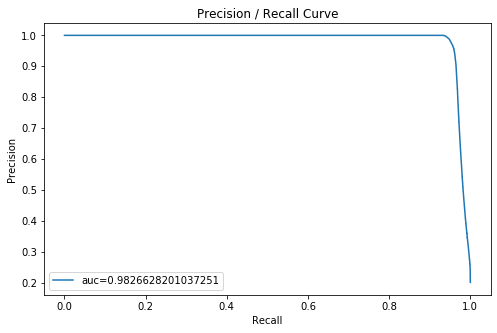

Average PR Score 0.9826628201037251


In [22]:
pred_val_proba_gb = predict_proba_positive(clf_gb, val_pool)
plot_pr_curve(y_val.label_is_attack.values, pred_val_proba_gb)

Classification Report:
              precision    recall  f1-score   support

           0      0.991     0.993     0.992   1348471
           1      0.964     0.957     0.961    274823

    accuracy                          0.987   1623294
   macro avg      0.978     0.975     0.976   1623294
weighted avg      0.987     0.987     0.987   1623294

Confusion Matrix:


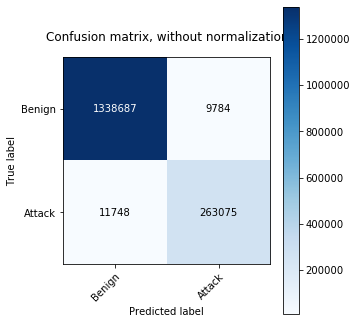

Misclassifications by attack category:


,misclassified,total,percent_misclassified
Infilteration,11690,16193,0.721917
SQL Injection,1,9,0.111111
Brute Force -XSS,1,23,0.043478
Brute Force -Web,2,61,0.032787
Benign,9784,1348471,0.007256
DoS attacks-Slowloris,6,1099,0.005460
Bot,35,28619,0.001223
DDoS attacks-LOIC-HTTP,13,57619,0.000226


In [24]:
pred_val_gb = clf_gb.predict(X_val)
print_binary_performance(y_val, y_val.label_is_attack, pred_val_gb)

## 5. Deep Neural Network Model

In this section, we load the Deep Neural Network model trained in a previous [experiment](https://github.com/cstub/ml-ids/blob/master/notebooks/06_dl_classifier/dl-classifier.ipynb), to compare the models performance on the validation set with the performances of the other models trained in this notebook.

In [50]:
clf_dl = models.load_model('../06_dl_classifier/models/opt_model.h5')

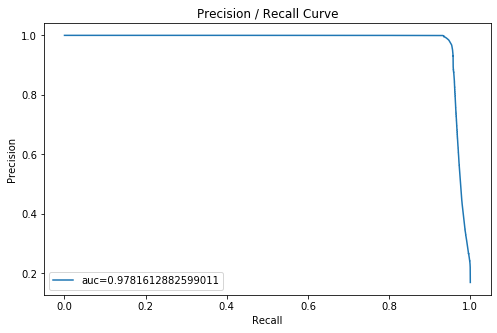

Average PR Score 0.9781612882599011


In [60]:
pred_val_proba_dl = kp.predict_proba(clf_dl, X_val)
plot_pr_curve(y_val.label_is_attack.values, pred_val_proba_dl)

Classification Report:
              precision    recall  f1-score   support

           0      0.991     0.993     0.992   1348471
           1      0.967     0.954     0.960    274823

    accuracy                          0.987   1623294
   macro avg      0.979     0.974     0.976   1623294
weighted avg      0.987     0.987     0.987   1623294

Confusion Matrix:


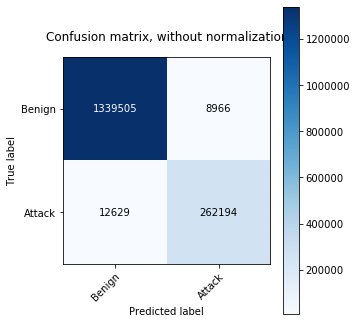

Misclassifications by attack category:


,misclassified,total,percent_misclassified
Infilteration,12466,16193,0.769839
SQL Injection,2,9,0.222222
Brute Force -Web,3,61,0.049180
Brute Force -XSS,1,23,0.043478
Benign,8966,1348471,0.006649
DoS attacks-Slowloris,6,1099,0.005460
Bot,104,28619,0.003634
DDoS attacks-LOIC-HTTP,45,57619,0.000781
SSH-Bruteforce,2,18759,0.000107


In [6]:
pred_val_dl = kp.predict(clf_dl, X_val)
print_binary_performance(y_val, y_val.label_is_attack, pred_val_dl)

## 6. Model Comparison

The following plot illustrates the Precision / Recall curves of the different models.

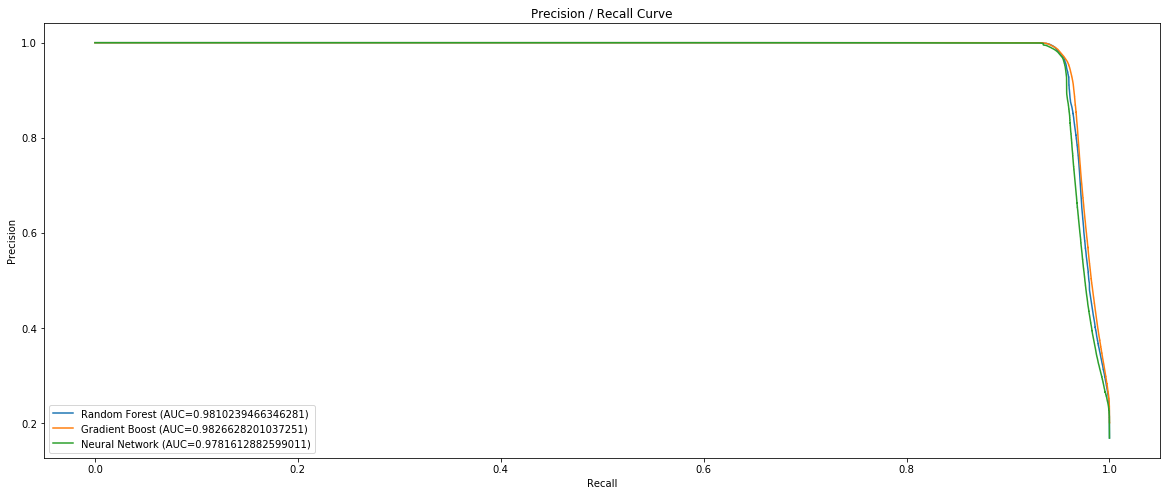

In [68]:
plot_pr_curves(y_val.label_is_attack, 
               {
                   'Random Forest': pred_val_proba_rf,
                   'Gradient Boost': pred_val_proba_gb,
                   'Neural Network': pred_val_proba_dl
               }, 
               size=(20, 8))

Comparing the results, we observe similar performance metrics across the different models.    

Both the Random Forest and Gradient Boosted Tree models perform better than the Neural Network though, achieving a slighty higher PR score, precision and recall.

Overall, the Gradient Boosted Tree model yields the best performance, having the highest PR score and recall in respect to the positive class, with only a slightly lower precision compared to the Random Forest model. Consequently, this model also returns the lowest amount of false-negatives. 

|Model|PR Score|Precision Positive|Recall Positive|False-Positives|False-Negatives|
|---|---|---|---|---|---|
|Random Forest         |0.98102|**0.967**|0.955|**8820**|12322|
|Gradient Boosted Trees|**0.98266**|0.964|**0.957**|9784|**11748**|
|Deep Neural Network   |0.97816|**0.967**|0.954|8966|12629|

We choose to use the Gradient Bosted Tree model going forward, as it achieves the best overall performance.

## 7. Precision / Recall Decision Boundary

All models presented in this notebook use class probabilities (in the interval `[0, 1]`) to predict the class of a given sample. In the case of binary classification a probability threshold for the positive class is chosen, that when exceeded, assigns the sample to the positive class.    
This probability threshold is called the *decision boundary* and is usually defined at the value of `0.5`.

Changing the decision boundary allows us to modify the metrics for precision and recall, as a decreased decision boundary leads to a lower precision but higher recall, whereas an increased decision boundary has the opposite result, a higher precision and lower recall. This is called the precision-recall tradeoff.

The following graphic illustrates this tradeoff by plotting the precision and recall for different values of the decision boundary. We can observe that an increase of precision or recall close to `1.00` leads to a drastic decrease in the opposite metric, so we have to be careful while tuning either one of them.

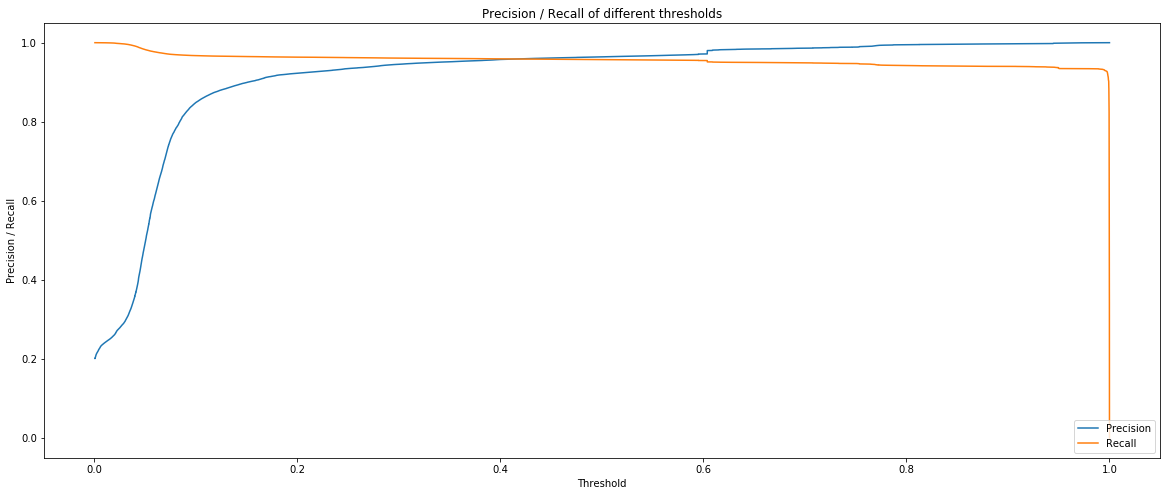

In [40]:
plot_pr_threshold_curves(y_val.label_is_attack, pred_val_proba_gb)

As the graphic depiction might be hard to interpret precisely, we now print the performance metrics for different choices of the decision boundary.    
The decision boundaries are chosen for a range of different target recalls ranging from `0.96 - 1.00` in steps of `0.01`. A specific decision boundary is determined by choosing a threshold from the precision-recall curve having the best precision while still satisfying the recall objective.

In [69]:
recalls = np.arange(0.96, 1, 0.01)

pred_val_proba_gb = predict_proba_positive(clf_gb, X_val)

for recall in recalls:
    b = best_precision_for_target_recall(y_val.label_is_attack, pred_val_proba_gb, target_recall=recall)
    pred_val_gb = predict_decision_boundary(clf_gb, X_val, b)
    print('Target Recall of {}'.format(recall))
    print('=====================')
    print('Decision Boundary: {}\n'.format(b))
    print(classification_report(y_val.label_is_attack, pred_val_gb, digits=3))
    print('')

Target Recall of 0.96
Decision Boundary: 0.3556530142617532

              precision    recall  f1-score   support

           0      0.992     0.990     0.991   1348471
           1      0.952     0.960     0.956    274823

    accuracy                          0.985   1623294
   macro avg      0.972     0.975     0.974   1623294
weighted avg      0.985     0.985     0.985   1623294


Target Recall of 0.97
Decision Boundary: 0.07857565826548527

              precision    recall  f1-score   support

           0      0.994     0.942     0.967   1348471
           1      0.774     0.970     0.861    274823

    accuracy                          0.947   1623294
   macro avg      0.884     0.956     0.914   1623294
weighted avg      0.956     0.947     0.949   1623294


Target Recall of 0.98
Decision Boundary: 0.05394934038983959

              precision    recall  f1-score   support

           0      0.995     0.832     0.906   1348471
           1      0.543     0.980     0.699    274

Comparing the different decision boundaries, we obtain the following performance metrics:

|Decision Boundary|Precision Positive|Recall Positive|F1 (macro)|
|---|---|---|---|
|0.5 (default)|0.964|0.957|0.976|
|0.3556       |0.952|0.960|0.974|
|0.0786       |0.774|0.970|0.914|
|0.0539       |0.543|0.980|0.803|
|0.0420       |0.380|0.990|0.675|
|0.0007       |0.201|1.000|0.327|

Increasing the recall to a value higher than `0.96`, we observe a drastic decrease in precision, as the number of false-positives increases dramatically.     
Given this insight and the fact that the default decision boundary at `0.5` already leads to a recall of approximately `0.96`, changing the decision boundary does not seem worthwhile, as the negative performance impact for further increasing the recall is to severe.

## 7. Performance on Test Set

In this section we use our best performing model to make predictions on the test set in order to obtain an unbiased performance estimate of the model.

The results demonstrate that the performance on the test set is very similar to the performance on the validation set, suggesting that we have built a model that generalizes well to unseen data, provided that the data has similar statistical characteristics as the test set.

Classification Report:
              precision    recall  f1-score   support

           0      0.991     0.993     0.992   1348471
           1      0.964     0.957     0.961    274824

    accuracy                          0.987   1623295
   macro avg      0.978     0.975     0.976   1623295
weighted avg      0.987     0.987     0.987   1623295

Confusion Matrix:


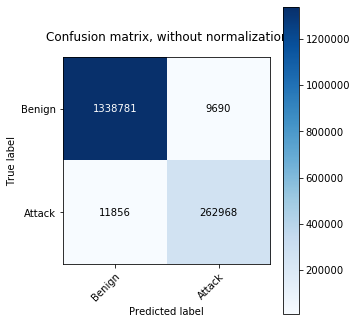

Misclassifications by attack category:


,misclassified,total,percent_misclassified
Infilteration,11811,16194,0.729344
Brute Force -Web,3,61,0.049180
Brute Force -XSS,1,23,0.043478
DoS attacks-Slowloris,8,1099,0.007279
Benign,9690,1348471,0.007186
Bot,24,28619,0.000839
DDoS attacks-LOIC-HTTP,9,57619,0.000156


In [71]:
pred_test_gb = clf_gb.predict(X_test)
print_binary_performance(y_test, y_test.label_is_attack, pred_test_gb)

## 8. Conclusion

In this notebook, we used different machine learning algorithms in combination with hyperparameter optimization to train a variety of models and compare their respective performances.    
Using the method of Gradient Boosted Trees we obtained the best performing binary classifier, achieving a very compelling performance on the validation and test sets, only falling short in correctly classifying malicious network traffic of the type `Infiltration`.    
As concluded in an earlier [experiment](https://github.com/cstub/ml-ids/blob/master/notebooks/06_dl_classifier/dl-classifier.ipynb), other approaches of reliably detecting infiltration attacks have to be explored in the future.